In [1]:
import os
import cv2, imutils
import numpy as np
import json
from matplotlib import pyplot as plt

In [70]:
def convert_coco_to_yolo(bbox, img_width, img_height):
    x_center = (bbox[0] + bbox[2]) / 2.0 / img_width
    y_center = (bbox[1] + bbox[3]) / 2.0 / img_height
    w = (bbox[2] - bbox[0]) / img_width
    h = (bbox[3] - bbox[1]) / img_height
    return f"{x_center} {y_center} {w} {h}"

def save_segmentation_and_bbox(inst_image_path, inst_json_path, segmentation_label_path, bbox_label_path):

    # get json objects
    object_json = {}
    
    with open(inst_json_path, "r") as file:
        object_json = json.load(file)
        
    label_dict = {}
    labels = list(object_json.keys())
    for label_name in labels:
        object_dict = object_json[label_name]
    
        for object_name in object_dict:
            
            info_dict = object_dict[object_name]
            # print(object_name, info_dict)
    
            label_id = info_dict["label"]
            inst_id = info_dict["inst_id"]
    
            if label_id in label_dict:
                label_dict[label_id].append(inst_id)
    
            else:
                label_dict[label_id] = [inst_id]

        
    
    # read image  
    image = cv2.imread(inst_image_path, cv2.IMREAD_UNCHANGED)
    
    image = image.astype(np.uint8)
    (img_h, img_w) = image.shape[:2]
    print(f"shape: {(img_h, img_w)}")
    unique, counts = np.unique(image, return_counts=True)
    unique_count_dict = dict(zip(unique, counts))
    
    # print("unique_count_dict", unique_count_dict)
    for id in unique_count_dict:
        # condition on the pixes
        top_limit = (img_h*img_w) * 0.7 # 80 % of the data
        top_limit = 700000
        
        lower_limit = 500 # pixels
    
        if unique_count_dict[id] < lower_limit or unique_count_dict[id] > top_limit:
            print(f"removing id: {id}, pixel: {unique_count_dict[id]}")
            continue
    
    
        for label_id in label_dict:
            inst_id_list = label_dict[label_id]
    
            if id in inst_id_list:
                break
    
        
        print(f"id: {id}, label: {labels[label_id]}, pixel: {unique_count_dict[id]}")
        
        inst_image = image.copy()
        mask = (inst_image != id)
        inst_image[mask] = 0
        
        mask = (inst_image == id)
        inst_image[mask] = 200
    
        ret, thresh = cv2.threshold(inst_image,100,255,0)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
    
        if len(cnts) == 0:
            print(cnts)
    
        # TODO: get multiple segmentation
        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        # print("Area: ", area)
    
        segmentation = c.reshape((-1, 2))
        segmentation_str = f""
    
        for count_1, seg in enumerate(segmentation):
    
            x_cor = format(seg[0] / img_w, '.6f')
            y_cor = format(seg[1] / img_h, '.6f')
    
            if count_1 == 0:
                segmentation_str += f"{x_cor}"
                segmentation_str += f" {y_cor}"
            else:
                segmentation_str += f" {x_cor}"
                segmentation_str += f" {y_cor}"
    
    
        x,y,w,h = cv2.boundingRect(c) # COCO Bounding box: (x-top left, y-top left,width, height)
        bbox = [x, y, x+w, y+h]
        bbox_yolo = convert_coco_to_yolo(bbox, img_w, img_h)
    
    
        # save segmentation label
        if segmentation_str:
            file_object = open(segmentation_label_path, "a")
            file_object.write(f"{label_id} {segmentation_str}\n")
            file_object.close()
    
        # save bbox label
        if bbox:
            file_object = open(bbox_label_path, "a")
            file_object.write(f"{label_id} {bbox_yolo}\n")
            file_object.close()
    
        # plt.figure(figsize = (6, 4))
        # plt.imshow(inst_image * 50)
        # plt.show()
        # break

In [71]:
inst_image_path = "instance.png"
inst_json_path = "object.json"


segmentation_label_path = "segmentation.txt"
bbox_label_path = "bbox.txt"

save_segmentation_and_bbox(inst_image_path, inst_json_path, segmentation_label_path, bbox_label_path)

shape: (1080, 1428)
removing id: 0, pixel: 760650
id: 1, label: banner, pixel: 38156
id: 2, label: brand, pixel: 10793
id: 3, label: shelf, pixel: 128954
id: 4, label: products, pixel: 4044
id: 5, label: products, pixel: 3177
id: 6, label: products, pixel: 5157
removing id: 7, pixel: 251
removing id: 8, pixel: 358
id: 9, label: products, pixel: 4758
id: 10, label: products, pixel: 2782
id: 11, label: products, pixel: 5099
id: 12, label: products, pixel: 1890
id: 13, label: products, pixel: 528
id: 14, label: products, pixel: 4690
id: 15, label: products, pixel: 1289
id: 16, label: products, pixel: 1189
id: 17, label: products, pixel: 4257
id: 18, label: products, pixel: 4223
id: 19, label: products, pixel: 1014
id: 20, label: products, pixel: 2035
id: 21, label: products, pixel: 2615
id: 22, label: products, pixel: 3266
id: 23, label: products, pixel: 2343
id: 24, label: products, pixel: 2891
removing id: 25, pixel: 40
removing id: 26, pixel: 28
removing id: 27, pixel: 217
id: 28, labe

In [3]:
inst_image = cv2.imread(inst_image_path, cv2.IMREAD_UNCHANGED)

In [4]:
inst_image.shape

(1080, 1428)

In [13]:
# read json
object_json = {}

with open(inst_json_path, "r") as file:
    object_json = json.load(file)

In [14]:
list(object_json.keys())

['products', 'shelf', 'testor', 'banner', 'brand']

In [16]:
# object_json["products"]

In [19]:
label_dict = {}
labels = list(object_json.keys())
for label_name in labels:
    object_dict = object_json[label_name]

    for object_name in object_dict:
        
        info_dict = object_dict[object_name]
        # print(object_name, info_dict)

        label_id = info_dict["label"]
        inst_id = info_dict["inst_id"]
        

        if label_id in label_dict:
            label_dict[label_id].append(inst_id)

        else:
            label_dict[label_id] = [inst_id]



In [23]:
def convert_coco_to_yolo(bbox, img_width, img_height):
    x_center = (bbox[0] + bbox[2]) / 2.0 / img_width
    y_center = (bbox[1] + bbox[3]) / 2.0 / img_height
    w = (bbox[2] - bbox[0]) / img_width
    h = (bbox[3] - bbox[1]) / img_height
    return f"{x_center} {y_center} {w} {h}"

In [34]:


segmentation_label_path = "segmentation.txt"
bbox_label_path = "bbox.txt"


image = cv2.imread(inst_image_path, cv2.IMREAD_UNCHANGED)

image = image.astype(np.uint8)
(img_h, img_w) = image.shape[:2]
print(f"shape: {(img_h, img_w)}")
unique, counts = np.unique(image, return_counts=True)
unique_count_dict = dict(zip(unique, counts))

print("unique_count_dict", unique_count_dict)
for id in unique_count_dict:
    # condition on the pixes
    top_limit = (img_h*img_w) * 0.7 # 80 % of the data
    top_limit = 700000
    
    lower_limit = 500 # pixels

    if unique_count_dict[id] < lower_limit or unique_count_dict[id] > top_limit:
        print(f"removing id: {id}, pixel: {unique_count_dict[id]}")
        continue


    for label_id in label_dict:
        inst_id_list = label_dict[label_id]

        if id in inst_id_list:
            break

    
    print(f"id: {id}, label: {labels[label_id]}, pixel: {unique_count_dict[id]}")
    
    inst_image = image.copy()
    mask = (inst_image != id)
    inst_image[mask] = 0
    
    mask = (inst_image == id)
    inst_image[mask] = 200

    ret, thresh = cv2.threshold(inst_image,100,255,0)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        print(cnts)

    # TODO: get multiple segmentation
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    print("Area: ", area)

    segmentation = c.reshape((-1, 2))
    segmentation_str = f""

    for count_1, seg in enumerate(segmentation):

        x_cor = format(seg[0] / img_w, '.6f')
        y_cor = format(seg[1] / img_h, '.6f')

        if count_1 == 0:
            segmentation_str += f"{x_cor}"
            segmentation_str += f" {y_cor}"
        else:
            segmentation_str += f" {x_cor}"
            segmentation_str += f" {y_cor}"


    x,y,w,h = cv2.boundingRect(c) # COCO Bounding box: (x-top left, y-top left,width, height)
    bbox = [x, y, x+w, y+h]
    bbox_yolo = convert_coco_to_yolo(bbox, img_w, img_h)


    # save segmentation label
    if segmentation_str:
        file_object = open(segmentation_label_path, "a")
        file_object.write(f"{label_id} {segmentation_str}\n")
        file_object.close()

    # save bbox label
    if bbox:
        file_object = open(bbox_label_path, "a")
        file_object.write(f"{label_id} {bbox_yolo}\n")
        file_object.close()

    # plt.figure(figsize = (6, 4))
    # plt.imshow(inst_image * 50)
    # plt.show()
    # break

shape: (1080, 1428)
unique_count_dict {0: 760650, 1: 38156, 2: 10793, 3: 128954, 4: 4044, 5: 3177, 6: 5157, 7: 251, 8: 358, 9: 4758, 10: 2782, 11: 5099, 12: 1890, 13: 528, 14: 4690, 15: 1289, 16: 1189, 17: 4257, 18: 4223, 19: 1014, 20: 2035, 21: 2615, 22: 3266, 23: 2343, 24: 2891, 25: 40, 26: 28, 27: 217, 28: 5212, 29: 4693, 30: 1275, 31: 3875, 32: 4429, 33: 590, 34: 238, 35: 2519, 36: 5354, 37: 3885, 38: 5126, 39: 658, 40: 2113, 41: 2982, 42: 2861, 43: 2106, 44: 2056, 45: 827, 46: 717, 47: 713, 48: 1003, 49: 712, 50: 731, 51: 1206, 52: 1587, 53: 1570, 54: 935, 55: 940, 163: 36953, 164: 120571, 165: 4080, 166: 4007, 167: 333, 168: 262, 169: 385, 170: 2469, 171: 488, 172: 213, 173: 2714, 174: 1887, 175: 2407, 176: 4249, 177: 4319, 178: 112, 179: 71, 180: 168, 181: 3120, 182: 214, 183: 369, 184: 287, 185: 148, 186: 147, 187: 128, 188: 158, 189: 3147, 190: 3147, 191: 3209, 192: 628, 193: 426, 194: 338, 195: 280, 196: 530, 197: 3599, 198: 325, 199: 1121, 200: 361, 201: 293, 202: 297, 203: 

In [37]:
### mask on the image

In [38]:
with open(segmentation_label_path, "r") as file:
    segmentation_mask = file.read()

In [52]:
# Read the image
image_path = "rgb.jpg"
image = cv2.imread(image_path)

# Iterate over each line in the segmentation mask
for line in segmentation_mask.split('\n'):
    if line.strip() == '':
        continue

    # Parse label and coordinates
    label, *coords = map(float, line.split())
    label = int(label)

    # Reshape coordinates to form the rectangle
    coordinates = np.array(coords, dtype=np.float32).reshape(-1, 2)
    coordinates *= np.array([image.shape[1], image.shape[0]])

    # Draw rectangle with a different color for each label
    color = tuple(map(int, np.random.randint(0, 255, 3)))
    cv2.polylines(image, [coordinates.astype(int)], isClosed=True, color=color, thickness=3)


In [62]:
with open(bbox_label_path, "r") as file:
    bbox_data = file.read()

# Read the image
image_path = "rgb.jpg"
image = cv2.imread(image_path)

# Iterate over each line in the bounding box data
for line in bbox_data.split('\n'):
    if line.strip() == '':
        continue

    # Parse label and coordinates
    label, x_center, y_center, width, height = map(float, line.split())
    label = int(label)

    # Calculate bounding box coordinates
    x_min = int((x_center - width / 2) * image.shape[1])
    y_min = int((y_center - height / 2) * image.shape[0])
    x_max = int((x_center + width / 2) * image.shape[1])
    y_max = int((y_center + height / 2) * image.shape[0])
    # Draw bounding box with a different color for each label
    color = tuple(map(int, (240, 230, 250)))
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)



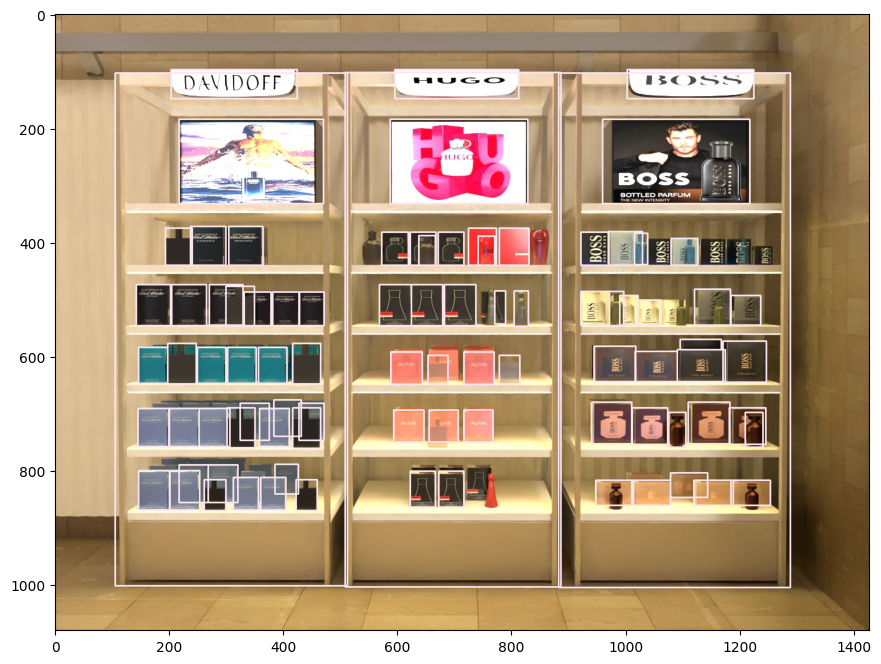

In [63]:
plt.figure(figsize = (12, 8))
# Convert image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()